In [1]:
import itertools
import typing
import logging
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import QuantLib as ql
import yfinance as yf
import pandas_market_calendars as mcal
import datetime
import time
from pathlib import Path
import os

# Self-written modules
from yq.utils.time import timeit
from yq.utils import io
from yq.scripts import models, model_eval
from yq.scripts import heston, gbm
from yq.utils import option
from yq.utils import calendar
from yq.scripts import simulation as sm
from yq.utils import path as yq_path
from yq.utils import log
from sc import constants as cs
from sc import payoff as po

file_location = os.getcwd()
cur_dir = Path(file_location).parent # ipynb cannot use __file__
#cur_dir = Path(__file__).parent
logger_yq = log.setup_logger('yq', yq_path.get_logs_path(cur_dir=cur_dir).joinpath(f"log_file_{datetime.datetime.now().strftime('%Y%m%d_%H')}.log"))
logger_yq.info("\n##########START##########\n")

In [86]:
pd.set_option('display.max_rows', None) # TODO:
# TODO: Take the values from yq_script
model = 'gbm' #TODO:
dir_list = ['20231114_024525_7']
max_sigma = 0.5

# For different methodologies, we want to get the RMSE for the ppd_payous against actual price
# Change to itertools
RMSE_list = []
for uid in dir_list:
    paths_arr, dates = sm.read_sim_data(model, uid, cs.INITIAL_PROD_PRICING_DATE, cs.FINAL_PROD_PRICING_DATE)
    n_sim = len(paths_arr[0])
    n_ppd = len(paths_arr) # Some missing lists in n_ppd
    print(n_sim, n_ppd)

    actual_price = po.get_product_price(cs.FINAL_PROD_PRICING_DATE).rename(columns={'Price': 'actual_price'})
    # Actual price for the product price period
    actual_price = actual_price[actual_price.index >= cs.INITIAL_PROD_PRICING_DATE]
    # logger_yq.info(f'Actual_price df is\n{actual_price}')

    payouts_compare = pd.DataFrame({'ppd_payouts': np.zeros(len(actual_price))})
    payouts_compare.index = pd.to_datetime(actual_price.index)
    payouts_compare = pd.concat([payouts_compare, actual_price], axis=1)
    actual_price.copy(deep=True)

    # Average payouts of all the sim paths on each ppd
    # display(payouts_compare)
    for ppd in range(n_ppd):
        # Need to rename columns first
        # logger_yq.info(f'pdd = {ppd} paths_arr[ppd] is\n{paths_arr[ppd]}')
        # Payouts for all the paths on one day of the price period (multiple paths)
        if (len(paths_arr[ppd]) != 0):
            paths_payout = po.pricing_multiple(paths_arr[ppd])
            payouts_compare.loc[pd.Timestamp(dates[ppd]),'ppd_payouts'] =  np.mean(paths_payout)
        else:
            logger_yq.error(f"Path payouts cannot be 0")
    # Payouts for the entire pricing period
    #display(payouts_compare)

    

10 67


In [87]:
payouts_compare

,ppd_payouts,actual_price
Date,,
2023-08-09,1052.834728,961.4
2023-08-10,980.987444,968.1
2023-08-11,952.130510,964.3
2023-08-14,1050.296743,964.6
2023-08-15,1053.524283,961.7
2023-08-16,961.851267,956.1
2023-08-17,1051.748923,949.2
2023-08-18,1060.605181,945.6
2023-08-21,1058.501118,946.1


0


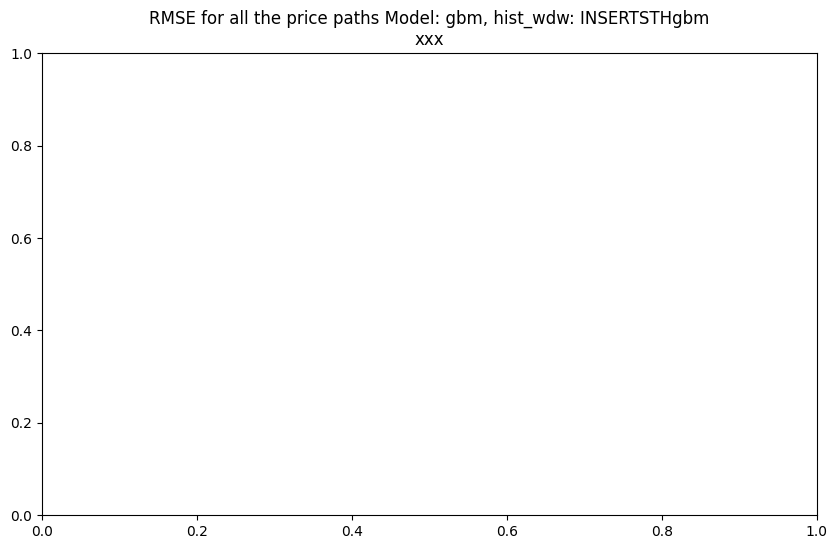

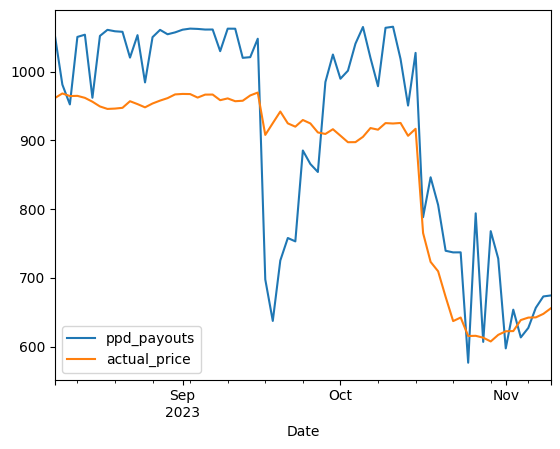

In [90]:
# TODO: Plot payouts_compare
fig, ax = plt.subplots(figsize=(10,6)) 
if model == 'heston':
    title_str = f"Model: {model}, hist_wdw: INSERTSTH{model}, max_sigma: {max_sigma}"
else:
    # TODO: Do sth for gbm
    title_str = f"RMSE for all the price paths Model: {model}, hist_wdw: INSERTSTH{model}"
    pass
subtitle_str = f"xxx"
plt.title(f"{title_str}\n{subtitle_str}")
payouts_compare.plot()
# # payouts_compare = payouts_compare[payouts_compare['ppd_payouts'] != 0]
# # Replace leading/trailing zeros with NaN
# payouts_compare['ppd_payouts'].replace(to_replace=0, method='ffill', inplace=True)  # Forward fill
# payouts_compare['ppd_payouts'].replace(to_replace=0, method='bfill', inplace=True)  # Backward fill

average = 0
compare_clean = payouts_compare.copy(deep=True)
if model == 'heston':
    # average = np.mean(compare_clean['ppd_payouts'])
    # compare_clean = compare_clean[abs(compare_clean['ppd_payouts'] - average) / average < 0.2]

    compare_clean = compare_clean[(compare_clean.index < pd.Timestamp('2023-09-15')) | (compare_clean.index > pd.Timestamp('2023-10-01'))]
compare_clean = compare_clean[compare_clean['ppd_payouts'] > 0]
print(average)
# display(compare_clean)

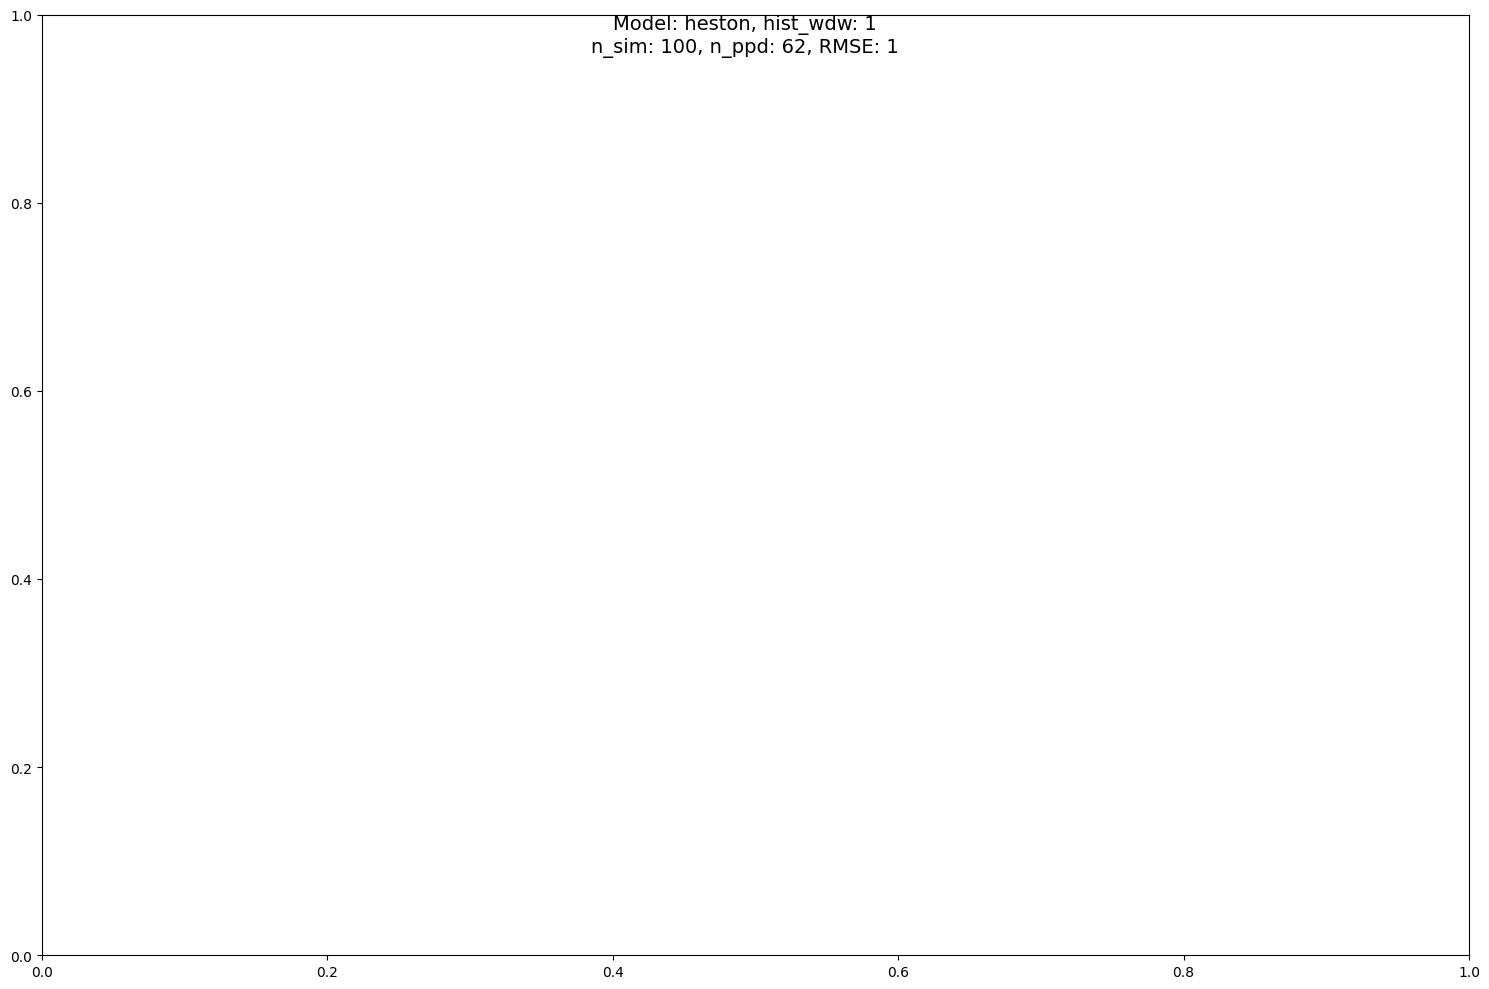

In [82]:


plt.subplots(figsize=(15, 10))
plt.tight_layout()
title_str = f"Model: {model}, hist_wdw: 1"
subtitle_str = f"n_sim: {n_sim}, n_ppd: {n_ppd}, RMSE: 1"
plt.suptitle(f"{title_str}\n{subtitle_str}", fontsize=14)  # Adjust font size as needed


compare_clean.plot()
plt.close()

In [76]:
# stor_dir = yq_path.get_plots_path(Path(file_location).parent).joinpath('eval', model)
# stor_dir.mkdir(parents=True, exist_ok=True)
# file_path = stor_dir.joinpath(f'#############.png') # TODO: Rename
# plt.savefig(file_path, bbox_inches='tight')
# plt.close()

# Change to final compare


# TODO: Write the list into a csv file or sth

310.38595543617794 62.89731511670755


In [ ]:
# Smooth but not that useful
import statsmodels.api as statsm

# compare_clean.plot()

# Assuming payouts_compare has a 'ppd_payouts' column
compare_clean = compare_clean.reset_index(drop=True)
x = compare_clean.index
y = compare_clean['ppd_payouts']

# Lowess smoothing
lowess = statsm.nonparametric.lowess(y, x, frac=0.1)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Original')
plt.plot(lowess[:, 0], lowess[:, 1], label='Smoothed', color='red')
plt.title('Payouts Comparison with Smoothed Line')
plt.legend()
plt.show()
plt.legend(loc='upper right')